# Using Transition Matrix Methods under IndShockConsumerType

By William Du

This Jupyter Notebook demonstrates how to non-stochastically simulate an economy with transition matrices with functions under the IndShockConsumerType.

The three key functions to non stochastically simulate are:

##### define_distribution_grid
- computes the grid of normalized market resources and the grid permanent income storing each as attributes of self.

###### calc_transition_matrix 
- computes transition matrix (matrices), a grid of consumption policies, and a grid asset policies stored as attributes of self. If the problem has a finite horizon, this function stores lists of transition matrices, consumption policies and asset policies grid for each period as attributes of self.

##### calc_ergodic_dist 
- computes the ergodic distribution stored as attributes. The distribution is stored as a vector (self.vec_erg_dstn) and as a grid (self.erg_dstn)



## Set up Computational Environment

In [1]:

from HARK.ConsumptionSaving.ConsIndShockModel_TRANMAT_original import IndShockConsumerType
import time
from copy import copy, deepcopy
import numpy as np
import matplotlib.pyplot as plt


C:\Users\wdu\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\wdu\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\wdu\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Set up the Dictionary

In [2]:
Dict={
    # Parameters shared with the perfect foresight model
    "CRRA":2,                             # Coefficient of relative risk aversion
    "Rfree": 1.05**.25,                   # Interest factor on assets
    "DiscFac": 0.975,                # Intertemporal discount factor
    "LivPrb" : [.99375],                  # Survival probability
    "PermGroFac" :[1.00],                 # Permanent income growth factor

    # Parameters that specify the income distribution over the lifecycle
    "PermShkStd" :  [(.005*4/11)**.5],     # Standard deviation of log permanent shocks to income
    "PermShkCount" : 5,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkStd" : [.3],                   # Standard deviation of log transitory shocks to income
    "TranShkCount" : 5,                    # Number of points in discrete approximation to transitory income shocks
    "UnempPrb" : 0.05,                     # Probability of unemployment while working
    "IncUnemp" :  .2,                      # Unemployment benefits replacement rate
    "UnempPrbRet" : 0.0005,                # Probability of "unemployment" while retired
    "IncUnempRet" : 0.0,                   # "Unemployment" benefits when retired
    "T_retire" : 0,                        # Period of retirement (0 --> no retirement)
    "tax_rate" : 0.0,                      # Flat income tax rate (legacy parameter, will be removed in future)

    # A few other parameters
    "BoroCnstArt" : 0.0,                   # Artificial borrowing constraint; imposed minimum level of end-of period assets
    "vFuncBool" : False,                   # Whether to calculate the value function during solution
    "CubicBool" : False,                   # Preference shocks currently only compatible with linear cFunc
    "T_cycle" : 1,                         # Number of periods in the cycle for this agent type

    # Parameters only used in simulation
    "AgentCount" : 100000,                 # Number of agents of this type
    "T_sim" : 1000,                        # Number of periods to simulate
    "aNrmInitMean" : np.log(1.0)-(.5**2)/2,# Mean of log initial assets
    "aNrmInitStd"  : .5,                   # Standard deviation of log initial assets
    "pLvlInitMean" : 0.0,                  # Mean of log initial permanent income
    "pLvlInitStd"  : 0.0,                  # Standard deviation of log initial permanent income
    "PermGroFacAgg" : 1.0,                 # Aggregate permanent income growth factor
    "T_age" : None,                        # Age after which simulated agents are automatically killed
    
    # Parameters for constructing the "assets above minimum" grid
    "aXtraMin" : 0.001,                    # Minimum end-of-period "assets above minimum" value
    "aXtraMax" : 50,                       # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 50,                     # Number of points in the base grid of "assets above minimum"
    "aXtraNestFac" : 3,                    # Exponential nesting factor when constructing "assets above minimum" grid
    "aXtraExtra" : [None],                 # Additional values to add to aXtraGrid
     }


## Create an Instance of IndShockConsumerType and Solve

In [3]:

example1 = IndShockConsumerType(**Dict)
example1.cycles = 0
example1.solve()


GPFRaw                 = 0.993461 
GPFNrm                 = 0.995083 
GPFAggLivPrb           = 0.987252 
Thorn = APF            = 0.993461 
PermGroFacAdj          = 0.998371 
uInvEpShkuInv          = 0.998371 
VAF                    = 0.967328 
WRPF                   = 0.218765 
DiscFacGPFNrmMax       = 0.984660 
DiscFacGPFAggLivPrbMax = 0.994090 


# Simulation: Transition Matrix vs Monte Carlo

This section compares monte carlo methods against the transition matrix approach in computing aggregate consumption and aggregate assets.

## Method 1: Monte Carlo 

In [4]:

# Simulation Parameters 

#Simulate
example1.track_vars = ['aLvl'] # Track level of assets
example1.initialize_sim()
example1.simulate() #Simulate with Monte Carlo

#Compute Aggregate Consumption and Aggregate Assets
Monte_Carlo_Consumption = np.mean((example1.state_now['mNrm'] - example1.state_now['aNrm'])*example1.state_now['pLvl']) #Aggregate Consumption
Monte_Carlo_Assets = np.mean(example1.state_now['aNrm']*example1.state_now['pLvl']) #Aggregate Assets


## Method 2: Transition Matrices

In [5]:

example1.define_distribution_grid()
p = example1.dist_pGrid # Grid of permanent income levels

example1.calc_transition_matrix()
c = example1.cPol_Grid # Normalized Consumption Policy Grid
asset = example1.aPol_Grid # Normalized Asset Policy Grid

example1.calc_ergodic_dist()
vecDstn = example1.vec_erg_dstn # Distribution of market resources and permanent income as a vector (m*p)x1 vector where 
# m is the number of market resource gridpoints and p is the number of permanent income gridpoints


In [6]:

#Compute Aggregate Consumption and Aggregate Assets
gridc = np.zeros( (len(c),len(p)) )
grida = np.zeros( (len(asset),len(p)) )

for j in range(len(p)):
    gridc[:,j] = p[j]*c # unnormalized Consumption policy grid
    grida[:,j] = p[j]*asset # unnormalized Asset policy grid
    
AggC = np.dot(gridc.flatten(), vecDstn) #Aggregate Consumption
AggA = np.dot(grida.flatten(), vecDstn) #Aggregate Assets


In [7]:

Asset_Lvls = [] # list of aggregate assets for different sized permanent income grids. This list will be used later to compare 
# how the grid size influences the computation

for i in range(3): # Simulate aggregate assets with three permanent income grids.

    example1.define_distribution_grid(num_pointsP = 50 + 40*i) # set grid size of permanent income grid
    p = example1.dist_pGrid # Grid of permanent income levels

    example1.calc_transition_matrix()
    c = example1.cPol_Grid # Normalized Consumption Policy Grid
    asset = example1.aPol_Grid # Normalized Asset Policy Grid

    example1.calc_ergodic_dist()
    vecDstn = example1.vec_erg_dstn # Distribution of market resources and permanent income as a vector (m*p)x1 vector where 
    # m is the number of market resource gridpoints and p is the number of permanent income gridpoints



    grida = np.zeros( (len(asset),len(p)) )

    for j in range(len(p)):
        grida[:,j] = p[j]*asset # unnormalized Asset policy grid

    AggA = np.dot(grida.flatten() ,vecDstn) #Aggregate Assets

    Asset_Lvls.append(AggA)

### Comparing Steady State Outputs of Both Methods

In [8]:
print('TranMatrix Assets = ' + str(AggA[0]))
print('Simulated Assets = ' +str(Monte_Carlo_Assets))

print('TranMatrix Consumption = ' + str(AggC[0]))
print('Simulated Consumption = ' +str(Monte_Carlo_Consumption))

TranMatrix Assets = 1.2671163879002465
Simulated Assets = 1.2845364936075478
TranMatrix Consumption = 1.007147924907855
Simulated Consumption = 1.0156188197157066


### Comparing Simulated Path of Aggregate Assets

The following code plots the path of aggregate assets simulate from both Monte Carlo methods and transition matrix methods.

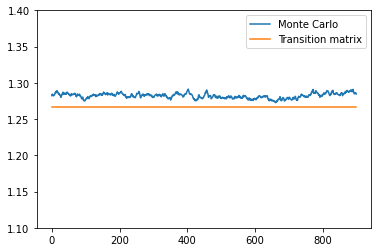

In [9]:

aLvls =[] # Time series of aggregate assets

for i in range(example1.T_sim):
    aLvls.append(np.mean(example1.history['aLvl'][i])) #compute mean of aggregate assets across all agents for each period of the simulation
aLvls = np.array(aLvls)

aLvl_tran_mat = []
dstn = vecDstn
for i in range(example1.T_sim-100):

    A_val = np.dot(grida.flatten(),dstn) 
    
    aLvl_tran_mat.append(A_val)
    dstn = np.dot( example1.tran_matrix,dstn)

plt.plot(aLvls[100:], label = 'Monte Carlo') # Plot time series path of aggregate assets using Monte Carlo simulation methods
plt.plot(aLvl_tran_mat , label = 'Transition matrix') # Plot time series path of aggregate assets computed using transition matrix
plt.legend()
plt.ylim([1.1,1.4])
plt.show()



### Precision vs Accuracy

Notice the mean level of aggregate assets differ between both simulation methods. The transition matrix plots a perfectly horizontal line as the initial distribution of agents across market resources and permanent is the unit eigenvector of the steady state transition matrix. Thus, as we take the produce of the transition matrix and the initial distribution, the new distribution does not change, implying the level of aggregate assets does not change. In contrast, the time series path simulated from Monte Carlo methods vacillates. This is because Monte Carlo methods are truly stochastic, randomly drawing shocks from a income distribution, while transition matrix methods are non-stochastic, the shock values are preset and the grid over market resources have is fixed. This contrast highlights the limitation of both methods, the monte carlo leads to a more accurate, yet less precise, level of aggregate assets while the transition matrix leads in precision but lacks  accuracy.  

### Increasing the number of permanent income grid points improves accuracy

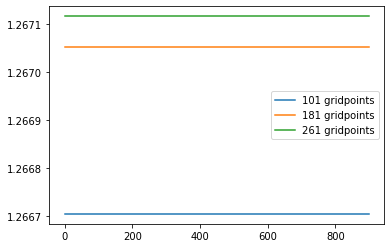

In [10]:
plt.plot(np.ones(example1.T_sim-100)*Asset_Lvls[0] , label = '101 gridpoints') # Plot time series path of aggregate assets computed using transition matrix
plt.plot(np.ones(example1.T_sim-100)*Asset_Lvls[1] , label = '181 gridpoints') 
plt.plot(np.ones(example1.T_sim-100)*Asset_Lvls[2] , label = '261 gridpoints') 
plt.legend()
plt.show()

## Distribution of Normalized Market Resources

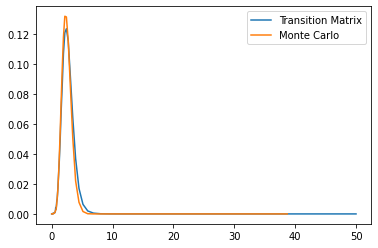

In [11]:

mdstn = np.zeros(48) 

for i in range(48):
    mdstn[i] = np.sum(example1.erg_dstn[i]) #distribution of normalized market resources

h = np.histogram(example1.state_now['mNrm'],bins=example1.dist_mGrid)[0]/np.sum(np.histogram(example1.state_now['mNrm'],bins=example1.dist_mGrid)[0]) #Form Monte Carlo wealth data and put into histogram/bins
plt.plot(example1.dist_mGrid,mdstn,label='Transition Matrix') # distribution using transition matrix method 
plt.plot(example1.dist_mGrid[:-1],h , label = 'Monte Carlo') #distribution using Monte Carlo
plt.legend()
plt.show()


## Distributions of Permanent Income 

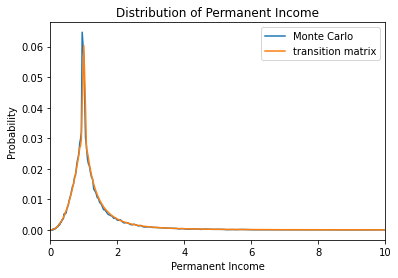

In [12]:

dstn = example1.erg_dstn

pdstn = np.zeros(len(dstn[0]))
for i in range(len(pdstn)):
    pdstn[i] = np.sum(dstn[:,i])
    
h = np.histogram(example1.state_now['pLvl'],bins=example1.dist_pGrid)[0]/np.sum(np.histogram(example1.state_now['pLvl'],bins=example1.dist_pGrid)[0]) #Form Monte Carlo wealth data and put into histogram/bins
plt.plot(example1.dist_pGrid[:-1],h,label='Monte Carlo') #distribution using Monte Carlo
plt.plot(example1.dist_pGrid,pdstn , label = 'transition matrix')
plt.ylabel('Probability')
plt.xlim([0,10.0])
plt.xlabel('Permanent Income')
plt.title('Distribution of Permanent Income')
plt.legend()
plt.show()


# Distribution of Wealth

In [13]:
#Compute all possible mLvl values given permanent income grid and normalized market resources grid

mLvl_vals = []

for m in example1.dist_mGrid:
        
    for p in example1.dist_pGrid:
        
        mLvl_vals.append(m*p)

mLvl_vals = np.array(mLvl_vals)
        

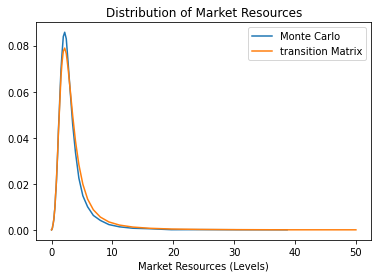

In [14]:

mLvl = example1.state_now['mNrm'] * example1.state_now['pLvl'] #market resources from Monte Carlo Simulations
pmf = example1.jump_to_grid_fast(mLvl_vals, vecDstn, example1.dist_mGrid) # probabilities/distribution from transition matrix methods
h = np.histogram(mLvl,bins=example1.dist_mGrid)[0]/np.sum(np.histogram(mLvl,bins=example1.dist_mGrid)[0]) #Form Monte Carlo wealth data and put into histogram/bins

plt.plot(example1.dist_mGrid[:-1],h , label = 'Monte Carlo') #distribution using Monte Carlo
plt.plot(example1.dist_mGrid,pmf, label = 'transition Matrix')
plt.xlabel('Market Resources (Levels)')
plt.title('Distribution of Market Resources')
plt.legend()
plt.show()


# Calculating the Path of Consumption given an Perfect foresight MIT shock

This section details an experiment to exhibit how to the transition matrix method can be utilized to compute the paths of aggregate consumption and aggregate assets given a pertubation in a variable for one period. In particular, in this experiment, in period t=0, agents learn that there will be a shock in the Discount Factor in period t=10. Given this, the simulated paths of aggregate consumption and aggregate assets will be computed and plotted. 



### Compute Steady State Distribution

We will want the simulation to begin at the economy's steady state. Therefore first we will compute the steady state distribution over market resources and permanent income. This will be the distribution for which the computed transition matrices will be applied/multiplied to. 

In [15]:

ss = deepcopy(example1)

ss.cycles = 0
ss.solve()

ss.define_distribution_grid()
p = ss.dist_pGrid # Grid of permanent income 

ss.calc_transition_matrix()
c = ss.cPol_Grid # Normalized Consumption Policy grid
a = ss.aPol_Grid #Normalized Asset Policy grid

ss.calc_ergodic_dist()
vecDstn = ss.vec_erg_dstn # Steady State Distribution as a vector (m*p x 1) where m is the number of gridpoints on the market resources grid 
#and p is the number of gridpoints on the permanent income grid


GPFRaw                 = 0.993461 
GPFNrm                 = 0.995083 
GPFAggLivPrb           = 0.987252 
Thorn = APF            = 0.993461 
PermGroFacAdj          = 0.998371 
uInvEpShkuInv          = 0.998371 
VAF                    = 0.967328 
WRPF                   = 0.218765 
DiscFacGPFNrmMax       = 0.984660 
DiscFacGPFAggLivPrbMax = 0.994090 


In [16]:

ss.T_sim = 1400
ss.initialize_sim()
ss.simulate()


{'aLvl': array([[2.28208447, 0.85378013, 1.03678129, ..., 0.66287236, 1.06829241,
         1.42715987],
        [1.86563613, 0.88134085, 1.19870031, ..., 1.15648667, 0.93942994,
         1.10717606],
        [1.66229209, 0.89762137, 1.34533666, ..., 1.13761691, 0.82648482,
         1.09642607],
        ...,
        [2.65438671, 0.85497639, 1.61069513, ..., 1.16436265, 1.51954039,
         1.43482885],
        [2.10082065, 0.61211664, 1.56973612, ..., 0.74585753, 1.26122115,
         1.39239903],
        [1.85203704, 0.41015865, 2.08330656, ..., 0.99076619, 1.52194747,
         1.35331196]])}

## Simulating With Harmenberg (2021) Method

Harmenberg (2021) method may also be implemented when simulating with transition matrices. In cells 16 and 17, we compute the steady distribution using Harmenberg's method.

For more information on Harmenberg's Method to dramatically improve simulation times see https://econ-ark.org/materials/harmenberg-aggregation?launch


In [17]:
# Change the income process to use Neutral Measure
ss.neutral_measure = True 
ss.update_income_process()

In [18]:

# Set up grid and calculate transition Matrices

ss.define_distribution_grid()
ss.calc_transition_matrix()

c = ss.cPol_Grid # Normalized Consumption Policy grid
a = ss.aPol_Grid #Normalized Asset Policy grid

ss.calc_ergodic_dist() #Calculate ergodic distribution
vecDstn_fast = ss.vec_erg_dstn #Distribution as a vector (mx1) where m is the number of gridpoint on the market resources grid


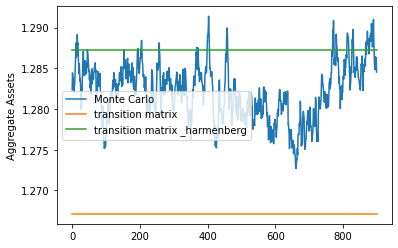

In [19]:

AggA_fast =  np.dot(ss.aPol_Grid,vecDstn_fast)

plt.plot(aLvls[100:], label = 'Monte Carlo') # Plot time series path of aggregate assets using Monte Carlo simulation methods
plt.plot(np.ones(example1.T_sim-100)*AggA , label = 'transition matrix') # Plot time series path of aggregate assets computed using transition matrix
plt.plot(np.ones(example1.T_sim-100)*AggA_fast , label = 'transition matrix _harmenberg') # Plot time series path of aggregate assets computed using transition matrix
plt.ylabel('Aggregate Assets')
plt.legend()
plt.show()


Note the Harmenberg method note only reduces the time of computation but also improves the accuracy of the simulated path of assets. 

### Solve an Agent who Anticipates a Change in the Discount Factor

Now that we have the steady state distributions of which simulations will begin from, we will now solve an agent who anticipates a change in the Discount Factor in period t=10. Solving the agent will provide the consumption policies to be used to calculate the transition matrices of this economy. 

In [20]:

# We will solve a finite horizon problem that begins at the steady state computed above. 
# Therefore parameters must be specified as lists, each item's index indicating the period of the horizon.

params = deepcopy(Dict)
params['T_cycle']= 20
params['LivPrb']= params['T_cycle']*[ss.LivPrb[0]]
params['PermGroFac']=params['T_cycle']*[1]
params['PermShkStd'] = params['T_cycle']*[ss.PermShkStd[0]]
params['TranShkStd']= params['T_cycle']*[ss.TranShkStd[0]]
params['Rfree'] = params['T_cycle']*[ss.Rfree]
params['DiscFac'] = params['T_cycle']*[ss.DiscFac]


FinHorizonAgent = IndShockConsumerType(**params)
FinHorizonAgent.cycles = 1

FinHorizonAgent.del_from_time_inv('Rfree') #delete Rfree from time invariant list since it varies overtime
FinHorizonAgent.add_to_time_vary('Rfree')

FinHorizonAgent.del_from_time_inv('DiscFac') #delete Rfree from time invariant list since it varies overtime
FinHorizonAgent.add_to_time_vary('DiscFac')

FinHorizonAgent.IncShkDstn = params['T_cycle']*[ss.IncShkDstn[0]]
FinHorizonAgent.cFunc_terminal_ = deepcopy(ss.solution[0].cFunc) # Set Terminal Solution as Steady State Consumption Function
FinHorizonAgent.track_vars = ['cNrm','pLvl'] 
FinHorizonAgent.T_sim = params['T_cycle']



### Implement perturbation in Discount Factor

In [21]:

dx = -.05 # Change in the Interest Rate
i = 10 # Period in which the change in the interest rate occurs

FinHorizonAgent.DiscFac = (i)*[ss.DiscFac] + [ss.DiscFac + dx] + (params['T_cycle'] - i -1 )*[ss.DiscFac] # Sequence of interest rates the agent faces



### Solve Agent

In [22]:

FinHorizonAgent.solve()


### Simulate with Monte Carlo

In [23]:

#Simulate with Monte Carlo

FinHorizonAgent.PerfMITShk = True

start = time.time()

FinHorizonAgent.initialize_sim()

#Begin simulation at steady state distribution of permanent income and permanent income
FinHorizonAgent.state_now['aNrm'] = ss.state_now['aNrm']
FinHorizonAgent.state_now['pLvl'] = ss.state_now['pLvl']

FinHorizonAgent.simulate()

print('seconds past : ' + str(time.time()-start))

#Compute path of aggregate consumption
clvl = []
for i in range(FinHorizonAgent.T_sim):
    
    C = np.mean(FinHorizonAgent.history['pLvl'][i,:]*FinHorizonAgent.history['cNrm'][i,:]) #Aggregate Consumption for period i
    clvl.append(C)


seconds past : 1.7260565757751465


### Calculate Transition Matrices

After the agent solves his problem, the consumption policies are stored in the solution attribute of self. calc_transition_matrix() will automatically call these attributes to compute the transition matrices.

In [24]:

start = time.time()
FinHorizonAgent.define_distribution_grid() 
FinHorizonAgent.calc_transition_matrix()
print('seconds past : ' + str(time.time()-start))

FinHorizonAgent.calc_agg_path(init_dstn = vecDstn) #calc_agg_path calculates the paths of aggregate assets and consumption storing each as attributes self.

AggC = FinHorizonAgent.AggC


seconds past : 89.30650019645691


calc_agg_path computes the paths of aggregate consumption and aggregate assets storing each time series as attributes of self given the initial distribution as an argument. This method is called after non stochastic simulation. 

### Calculate Transition matrices with Neutral Measure (Harmenberg 2021)
In the cell below we calculate the transition matrix while utilizing the neutral measure.

In [25]:

# Change Income Process to allow permanent income shocks to be drawn from neutral measure
FinHorizonAgent.neutral_measure = True
FinHorizonAgent.update_income_process()

# Calculate Transition Matrices
start = time.time()
FinHorizonAgent.define_distribution_grid() 
FinHorizonAgent.calc_transition_matrix()
print('seconds past : ' + str(time.time()-start))

#Calculate Macro Aggregates given Transition Matrices
FinHorizonAgent.calc_agg_path(init_dstn = vecDstn_fast)

AggC_fast = FinHorizonAgent.AggC #Path of Aggregate Consumption


seconds past : 1.0433852672576904


Notice the dramatic speed improvement.

### Path of Aggregate Consumption given an anticipated Discount Factor shock at $t=10$


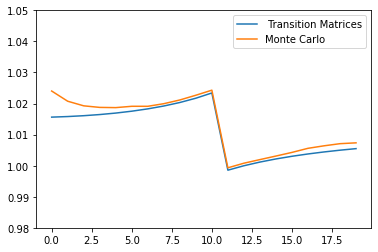

In [26]:

#plt.plot(AggC, label = 'without Harmenberg') #Without Neutral Measure
plt.plot(AggC_fast, label = ' Transition Matrices') #With Harmenberg Improvement
plt.plot(clvl, label = 'Monte Carlo')
plt.ylim([.98,1.05])
plt.legend()
plt.show()
